In [1]:
import sys
import os
sys.path.append('/Users/zhoupeng/Desktop/Athena')

In [2]:
from athena import Strategy, Backtest
from athena.data import TushareDataHandler
import pandas as pd
import matplotlib.pyplot as plt

from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [3]:
from dotenv import load_dotenv
load_dotenv()

tushare_token = os.getenv('tushare_token')

In [4]:
# tushare数据支持
data_handler = TushareDataHandler(start_date='20200101', end_date='20241201', token=tushare_token)

In [5]:
benchmark = data_handler.get_index_prices_from_tushare('399300.SZ')

In [6]:
# 获取指数成分
stock_list = data_handler.get_index_list(index_code='000300.SH') # 沪深300指数
stock_list = list(set(stock_list))
len(stock_list)

312

In [7]:
# unique_stock_list = stock_list[:5]

In [8]:
# 获取价格数据
# prices_df = data_handler.get_prices_from_tushare(stock_list, fields=['open', 'close'], sleep_time=0.5)
# prices_df.to_hdf('../athena/data/prices_data.h5', 'prices')

prices_df = pd.read_hdf('../athena/data/large_prices_data.h5', key='prices')

In [9]:
# 获取因子数据
# factors_df = data_handler.get_factors_from_tushare(stock_list, factors=['total_mv'], sleep_time=0.5)
# factors_df.to_hdf('../athena/data/factors_data.h5', 'factors')

factors_df = pd.read_hdf('../athena/data/large_factors_data.h5', key='factors')

In [10]:
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        pass

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.broker.current_position_status()
        print("我目前持仓情况:")
        print("多头仓位:", current_long_positions)
        print("空头仓位:", current_short_positions)

        day_factors = factors_df.loc[date] # 当天的因子数据
        sorted_factor_series = sort_the_factor(day_factors, 'total_mv') # 从高到低排因子

        print('因子排名前10的股票:')
        print(sorted_factor_series[:10].index.tolist())
        short_stocks = sorted_factor_series[:10].index.tolist()

        print('因子排名后10的股票:')
        print(sorted_factor_series[-10:].index.tolist())
        long_stocks = sorted_factor_series[-10:].index.tolist()

        target_percent = 1 / 20

        # 平仓
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print("关多仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Open')])
        for stock in current_short_positions:
            if stock not in short_stocks:
                print("关空仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Open')])
        
        # 这里的cash和assets value都应该被正常更新了

        # 调仓
        for stock in long_stocks:
            print("新开多仓/调仓:", stock)
            self.order_target_percent(stock, target_percent=target_percent, price=record[(stock, "Close")], short=False)
        for stock in short_stocks:
            print("新开空仓/调仓:", stock)
            self.order_target_percent(stock, target_percent=target_percent, price=record[(stock, "Close")], short=True)

        print("----------------------")


In [11]:
backtest = Backtest(SortedFactorInvestStrategy, prices_df, commission=.001, cash=100_0000, benchmark=benchmark)
res = backtest.run()

----------------------
2020-01-02 00:00:00: 
我目前持仓情况:
多头仓位: []
空头仓位: []
因子排名前10的股票:
['601398.SH', '601939.SH', '601318.SH', '600519.SH', '601288.SH', '601988.SH', '601857.SH', '601628.SH', '600036.SH', '600028.SH']
因子排名后10的股票:
['000807.SZ', '600803.SH', '000877.SZ', '600039.SH', '603486.SH', '002709.SZ', '000733.SZ', '300751.SZ', '300763.SZ', '300442.SZ']
新开多仓/调仓: 000807.SZ
新开多仓/调仓: 600803.SH
新开多仓/调仓: 000877.SZ
新开多仓/调仓: 600039.SH
新开多仓/调仓: 603486.SH
新开多仓/调仓: 002709.SZ
新开多仓/调仓: 000733.SZ
新开多仓/调仓: 300751.SZ
新开多仓/调仓: 300763.SZ
新开多仓/调仓: 300442.SZ
新开空仓/调仓: 601398.SH
新开空仓/调仓: 601939.SH
新开空仓/调仓: 601318.SH
新开空仓/调仓: 600519.SH
新开空仓/调仓: 601288.SH
新开空仓/调仓: 601988.SH
新开空仓/调仓: 601857.SH
新开空仓/调仓: 601628.SH
新开空仓/调仓: 600036.SH
新开空仓/调仓: 600028.SH
----------------------
----------------------
2020-02-03 00:00:00: 
我目前持仓情况:
多头仓位: ['000807.SZ', '600803.SH', '000877.SZ', '600039.SH', '603486.SH', '002709.SZ', '000733.SZ', '300751.SZ', '300763.SZ', '300442.SZ']
空头仓位: ['601398.SH', '601939.SH', '601318.SH', '6

In [12]:
# 在log里会有更详细的回测记录

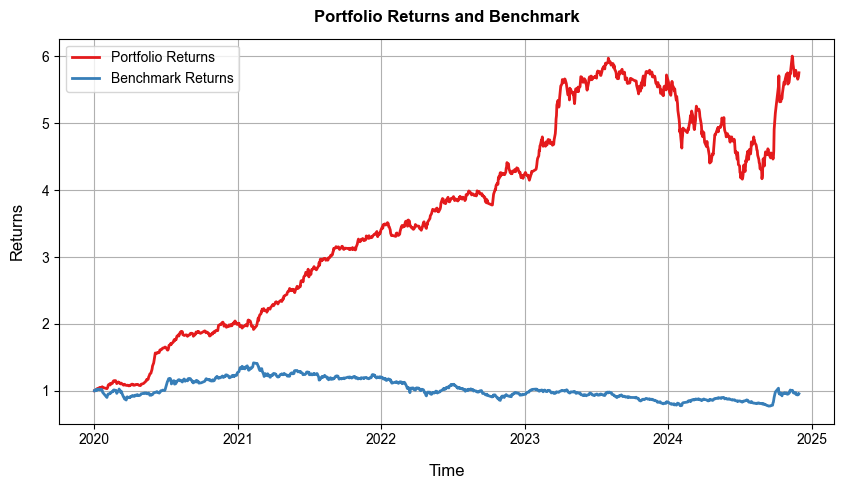

In [13]:
from athena.plotting import Visualization

visualization = Visualization(res)
visualization.plot_portfolio_returns()

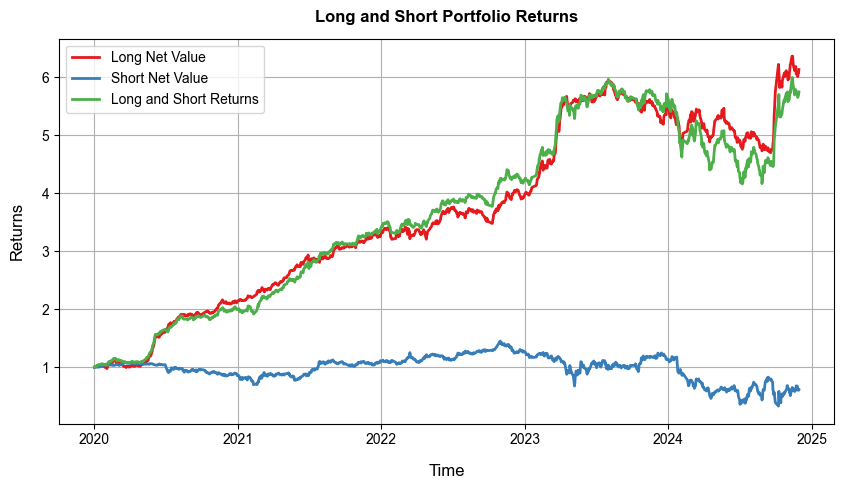

In [14]:
visualization.plot_long_short_portfolio_returns()

In [15]:
print(res.short_returns[-1])
print(res.long_returns[-1])

-386167.687046193
5132265.69777277


In [16]:
# 计算回测指标
metrics = visualization.calculate_metrics()
print("Backtest Metrics: \n")
for key, value in metrics.items():
    print(key+": "+ value)

Backtest Metrics: 

strategy_annualized_return: 44.84%
benchmark_annualized_return: -0.95%
strategy_annualized_volatility: 17.36%
benchmark_annualized_volatility: 19.71%
strategy_max_drawdown: -30.28%
benchmark_max_drawdown: -45.60%
sharpe_ratio: 2.47
alpha: 49.24%


In [17]:
pd.DataFrame(res.trades)

,symbol,short,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,open_commission,cumulative_return
0,000807.SZ,False,2020-01-02,2020-02-03,5.240000,4.25,9532.452281,-9527.590730,-18.893130,40.512922,49.950050,9.904724e+05
1,002709.SZ,False,2020-01-02,2020-02-03,21.160000,23.03,306.620573,559.830908,0.088374,7.061472,6.488091,9.910322e+05
2,603486.SH,False,2020-01-02,2020-02-03,21.030000,19.89,9.507201,-11.227243,-0.054208,0.189098,0.199936,9.910210e+05
3,000733.SZ,False,2020-01-02,2020-02-03,17.580000,17.10,98.082008,-50.480848,-0.027304,1.677202,1.724282,9.909705e+05
4,300751.SZ,False,2020-01-02,2020-02-03,145.230000,165.91,57.796436,1177.247516,0.142395,9.589007,8.393776,9.921478e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
530,300496.SZ,False,2024-08-07,2024-11-29,40.775747,55.05,4899.651220,69469.348616,35.006724,269.725800,199.786938,5.817493e+06
531,601628.SH,True,2024-08-07,2024-11-29,34.614638,42.10,11739.953955,-88778.430246,-21.624845,494.252061,406.374258,5.728714e+06
532,002841.SZ,False,2024-10-08,2024-11-29,39.417479,38.40,7926.874117,-8682.278917,-2.581289,304.391966,312.457396,5.720032e+06
533,000733.SZ,False,2024-10-08,2024-11-29,48.130490,46.26,5873.476948,-11540.680336,-3.886289,271.707044,282.693324,5.708491e+06


In [18]:
# 可以确认所有仓位都已经被清算
pd.DataFrame(res.open_positions)

""


因子分层测回测 total_mv, Bucket 1/5...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 4342957.786811937
因子分层测回测 total_mv, Bucket 2/5...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 1799650.9510452852
因子分层测回测 total_mv, Bucket 3/5...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 1180084.0011646217
因子分层测回测 total_mv, Bucket 4/5...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 797194.8423487507
因子分层测回测 total_mv, Bucket 5/5...
所有未平仓持仓已经清算完毕！
回测结束，总资金: 930218.9904778912


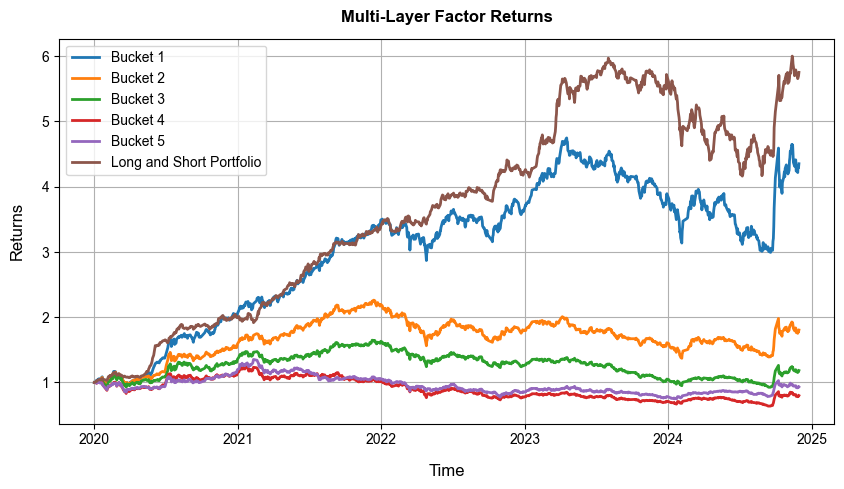

In [19]:
from athena.factor_research import run_factor_multiple_returns

# 对市值因子进行分层测试（例如分为5组）
layered_results = run_factor_multiple_returns(prices_df, factors_df, 'total_mv', num_buckets=5)
visualization.plot_factor_multiple_returns(layered_results, res.net_value)

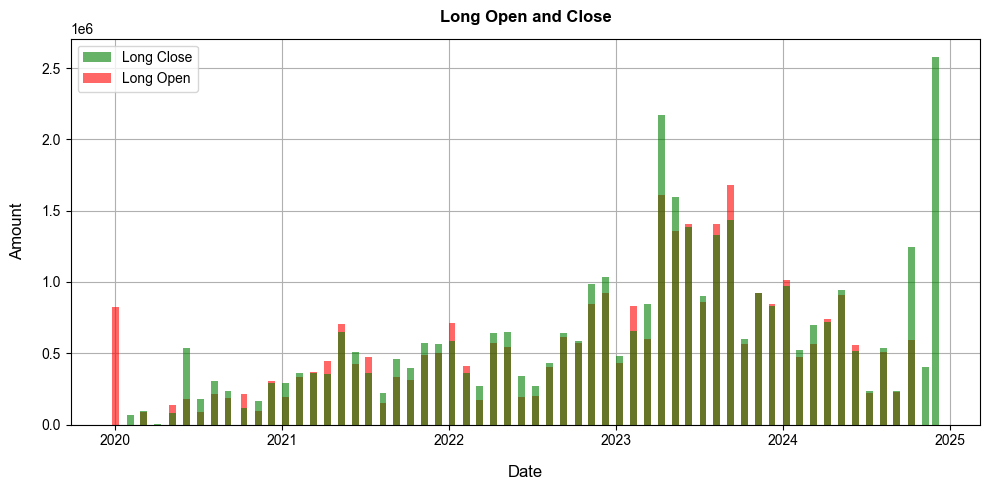

In [20]:
visualization.calculate_and_plot_open_close_volumes()